# Run Class 

**Arquitectura nueva:**
- `Run`: Data class vacía (solo almacena datos)
- `utils.py`: Funciones puras que procesan Run
- Sin lógica en la clase, todo en funciones externas

**Run almacena:**
- `filename`: Nombre del archivo
- `timestamps`: Tiempos de medición
- `temperatures`: DataFrame con temperaturas por sensor
- `sensor_ids`: Lista de IDs de sensores
- `offsets`: {sensor_id: offset} - media de (T_sensor - T_ref) en ventana [20-40 min]
- `offset_errors`: {sensor_id: error} - std de (T_sensor - T_ref) en ventana [20-40 min]
- `omitted_sensors`: {sensor_id: razón} - sensores omitidos
- `reference_id`: Sensor usado como referencia
- `is_valid`: False si BAD o keywords excluidas

**Importante:**
- Cada run calcula su propio error por sensor
- CalibSet usa estos errores para calcular **media ponderada**
- Runs con menor error tienen mayor peso en CalibSet

---

## 1. Setup

In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Añadir path del proyecto (src)
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Imports locales
from run import Run
from utils.config import load_config
from utils.run_utils import (
    load_run_from_file,
    map_sensor_ids_to_run,
    calculate_run_offsets,
    process_run_complete
)
from utils.filtering import (
    should_exclude_run,
    filter_valid_runs,
    get_discarded_sensors
)

print("[OK] Imports exitosos")

[OK] Imports exitosos


## 2. Cargar Config y Logfile

In [2]:
# Cargar configuración
config = load_config()
print(f"Config cargado con {len(config.get('sensors', {}).get('sets', {}))} sets")

# Cargar logfile
logfile_path = project_root / "data" / "LogFile.csv"
logfile = pd.read_csv(logfile_path)
print(f"Logfile cargado: {len(logfile)} runs")
print(f"Columnas: {list(logfile.columns[:10])}...")

Config cargado con 60 sets
Logfile cargado: 832 runs
Columnas: ['Filename', 'Selection', 'Liquid Media', 'Type', 'CalibSetNumber', 'Date', 'StartTime', 'HeatFinTime', 'FinTime', 'REF1_ID']...


## 3. Crear Run vacío

In [3]:
# Crear un Run vacío (solo filename)
filename = "20220531_ln2_r48176_r48177_48060_48479_7"
run = Run(filename)

print(f"Run creado: {run}")
print(f"  - filename: {run.filename}")
print(f"  - timestamps: {run.timestamps}")
print(f"  - temperatures: {run.temperatures}")
print(f"  - reference_channel: {run.reference_channel}")
print(f"  - offsets: {run.offsets}")
print(f"  - offset_errors: {run.offset_errors}")
print(f"  - omitted_channels: {run.omitted_channels}")
print(f"  - is_valid: {run.is_valid}")

print("\n[NOTA] Run es CIEGO - trabaja con canales (1-14), NO con sensor IDs")
print("  El mapping canal→sensor lo maneja CalibSet (sensors[0]=canal 1, etc.)")

Run creado: Run('20220531_ln2_r48176_r48177_48060_48479_7', valid=True, offsets=0, omitted=0)
  - filename: 20220531_ln2_r48176_r48177_48060_48479_7
  - timestamps: None
  - temperatures: None
  - reference_channel: None
  - offsets: {}
  - offset_errors: {}
  - omitted_channels: {}
  - is_valid: True

[NOTA] Run es CIEGO - trabaja con canales (1-14), NO con sensor IDs
  El mapping canal→sensor lo maneja CalibSet (sensors[0]=canal 1, etc.)


## 4. Cargar datos del archivo .txt (función de utils)

In [4]:
# Usar función de utils para cargar archivo
run = load_run_from_file(filename, config)

print(f"\nRun después de cargar archivo:")
print(f"  - timestamps: {len(run.timestamps) if run.timestamps is not None else 0} puntos")
print(f"  - temperatures shape: {run.temperatures.shape if run.temperatures is not None else 'None'}")

# Ver primeras filas de temperaturas
if run.temperatures is not None:
    print("\nPrimeras temperaturas (channels):")
    display(run.temperatures.head())

  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_7: 821 registros, 14 canales

Run después de cargar archivo:
  - timestamps: 821 puntos
  - temperatures shape: (821, 14)

Primeras temperaturas (channels):


,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,channel_9,channel_10,channel_11,channel_12,channel_13,channel_14
2022-06-06 09:55:13,76.54937,76.51696,76.52764,76.51530,76.45180,76.47502,76.50560,76.80446,76.46278,76.46259,76.49205,76.48339,76.50047,76.51208
2022-06-06 09:55:17,76.54655,76.51676,76.52694,76.51482,76.45241,76.47491,76.50663,76.80499,76.46344,76.46333,76.49255,76.48343,76.50235,76.51372
2022-06-06 09:55:20,76.54644,76.51537,76.52693,76.51458,76.45160,76.47422,76.50627,76.80493,76.46346,76.46326,76.49324,76.48324,76.50255,76.51444
2022-06-06 09:55:24,76.54730,76.51504,76.52667,76.51464,76.45150,76.47483,76.50737,76.80619,76.46406,76.46336,76.49387,76.48331,76.50339,76.51480
2022-06-06 09:55:28,76.54783,76.51503,76.52601,76.51472,76.45082,76.47492,76.50761,76.80616,76.46405,76.46396,76.49425,76.48352,76.50367,76.51542


## 5. Mapear sensor IDs desde logfile (función de utils)

In [5]:
# Usar función de utils para obtener sensor IDs del logfile
# NOTA: Run NO almacena sensor_ids (es ciego), esta función solo los retorna
sensor_ids = map_sensor_ids_to_run(run, logfile, config)

print(f"\nSensor IDs obtenidos del logfile:")
print(f"  - sensor_ids: {sensor_ids}")
print(f"  - Total: {len(sensor_ids)} sensores")
print(f"  - is_valid: {run.is_valid}")

print(f"\n[IMPORTANTE] Run NO almacena estos IDs")
print(f"  Run solo trabaja con canales (1-14)")
print(f"  El mapping canal→sensor se hace en CalibSet:")
print(f"    CalibSet.sensors[0] = Sensor(id={sensor_ids[0]}) → canal 1")
print(f"    CalibSet.sensors[1] = Sensor(id={sensor_ids[1]}) → canal 2")
print(f"    ...")


Sensor IDs obtenidos del logfile:
  - sensor_ids: [48060, 48061, 48062, 48063, 48202, 48203, 48204, 48205, 48476, 48477, 48478, 48479, 48176, 48177]
  - Total: 14 sensores
  - is_valid: True

[IMPORTANTE] Run NO almacena estos IDs
  Run solo trabaja con canales (1-14)
  El mapping canal→sensor se hace en CalibSet:
    CalibSet.sensors[0] = Sensor(id=48060) → canal 1
    CalibSet.sensors[1] = Sensor(id=48061) → canal 2
    ...


## 6. Calcular offsets respecto a referencia (función de utils)

In [6]:
# IMPORTANTE: Run NO tiene sensor_ids (es ciego)
# Usamos la variable sensor_ids obtenida en la celda anterior

# Elegir referencia: primer sensor del set (de los 12 que se calibran, NO canales 13-14)
ref_channel = 1  # Canal 1 = sensors[0] del set
ref_id = sensor_ids[0]  # ID del sensor en canal 1

print(f"Calculando offsets respecto a canal {ref_channel} (sensor {ref_id})")
print(f"  Sensores del set: {sensor_ids[:12]}")
print(f"  Referencias externas (ignoradas): {sensor_ids[12:14]}")

# Usar función de utils para calcular offsets
# Run trabaja con CANALES, no IDs
calculate_run_offsets(run, reference_channel=ref_channel, time_window=(20, 40), config=config)

print(f"\nRun después de calcular offsets:")
print(f"  - reference_channel: {run.reference_channel}")
print(f"  - offsets calculados: {len(run.offsets)} canales")
print(f"  - errores calculados: {len(run.offset_errors)} canales")
print(f"  - canales omitidos: {len(run.omitted_channels)}")

print("\nOffsets y errores por CANAL (Run es ciego a IDs):")
for channel in sorted(run.offsets.keys()):
    offset = run.offsets[channel]
    error = run.offset_errors.get(channel, 0.0)
    sensor_id = sensor_ids[channel-1] if channel <= len(sensor_ids) else '?'
    print(f"  Canal {channel} (sensor {sensor_id}): {offset:+.6f} ± {error:.6f} K")

if run.omitted_channels:
    print("\nCanales omitidos:")
    for channel, reason in run.omitted_channels.items():
        sensor_id = sensor_ids[channel-1] if channel <= len(sensor_ids) else '?'
        print(f"  Canal {channel} (sensor {sensor_id}): {reason}")

Calculando offsets respecto a canal 1 (sensor 48060)
  Sensores del set: [48060, 48061, 48062, 48063, 48202, 48203, 48204, 48205, 48476, 48477, 48478, 48479]
  Referencias externas (ignoradas): [48176, 48177]

Run después de calcular offsets:
  - reference_channel: 1
  - offsets calculados: 12 canales
  - errores calculados: 12 canales
  - canales omitidos: 0

Offsets y errores por CANAL (Run es ciego a IDs):
  Canal 1 (sensor 48060): +0.000000 ± 0.000000 K
  Canal 2 (sensor 48061): -0.033009 ± 0.000262 K
  Canal 3 (sensor 48062): -0.023258 ± 0.000363 K
  Canal 4 (sensor 48063): -0.034180 ± 0.000357 K
  Canal 5 (sensor 48202): -0.099238 ± 0.000340 K
  Canal 6 (sensor 48203): -0.072754 ± 0.000389 K
  Canal 7 (sensor 48204): -0.040070 ± 0.000354 K
  Canal 8 (sensor 48205): +0.260833 ± 0.000387 K
  Canal 9 (sensor 48476): -0.082102 ± 0.000373 K
  Canal 10 (sensor 48477): -0.082248 ± 0.000334 K
  Canal 11 (sensor 48478): -0.052354 ± 0.000330 K
  Canal 12 (sensor 48479): -0.065733 ± 0.00033

## 7. Visualizar offsets con barras de error

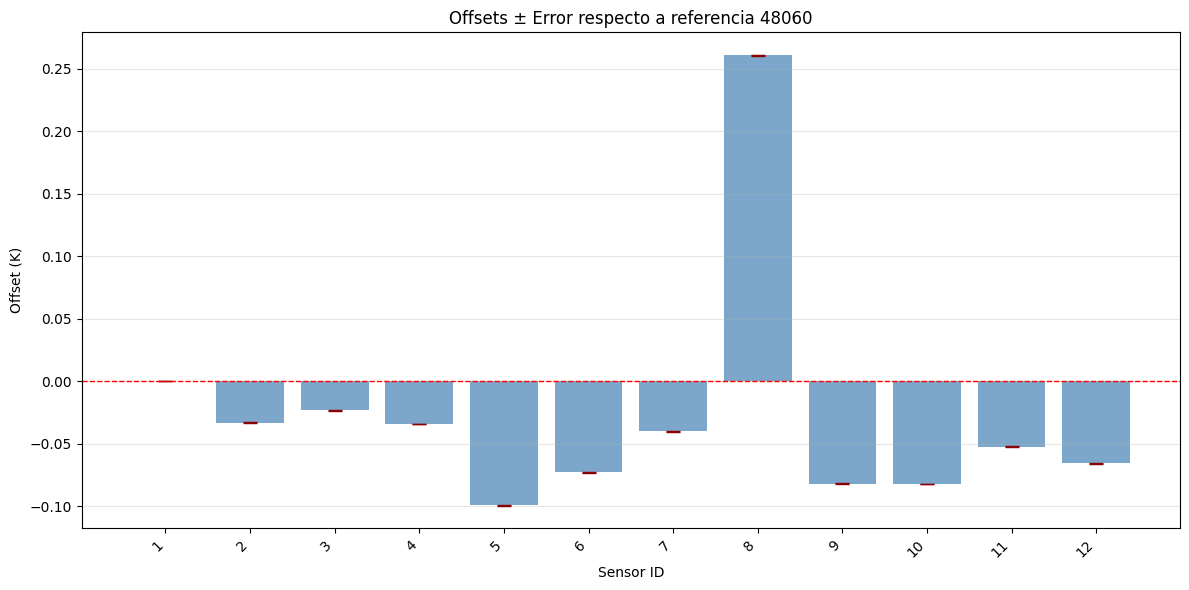


Estadísticas de offsets:
  Mean: -0.027009 K
  Std:  0.095056 K
  Min:  -0.099238 K
  Max:  0.260833 K

Estadísticas de errores:
  Mean error: 0.000319 K
  Min error:  0.000000 K
  Max error:  0.000389 K


In [7]:
# Plot de offsets con barras de error
if not run.offsets:
    print("⚠️  No hay offsets calculados para visualizar")
else:
    fig, ax = plt.subplots(figsize=(12, 6))

    sensor_ids = sorted(run.offsets.keys())
    offsets = [run.offsets[sid] for sid in sensor_ids]
    errors = [run.offset_errors.get(sid, 0.0) for sid in sensor_ids]

    # Barras con error bars
    x_pos = range(len(sensor_ids))
    ax.bar(x_pos, offsets, color='steelblue', alpha=0.7, yerr=errors, 
           capsize=5, error_kw={'linewidth': 1.5, 'ecolor': 'darkred'})
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sensor_ids, rotation=45, ha='right')
    ax.set_xlabel('Sensor ID')
    ax.set_ylabel('Offset (K)')
    ax.set_title(f'Offsets ± Error respecto a referencia {ref_id}')
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

    print(f"\nEstadísticas de offsets:")
    print(f"  Mean: {sum(offsets)/len(offsets):.6f} K")
    print(f"  Std:  {pd.Series(offsets).std():.6f} K")
    print(f"  Min:  {min(offsets):.6f} K")
    print(f"  Max:  {max(offsets):.6f} K")
    
    print(f"\nEstadísticas de errores:")
    print(f"  Mean error: {sum(errors)/len(errors):.6f} K")
    print(f"  Min error:  {min(errors):.6f} K")
    print(f"  Max error:  {max(errors):.6f} K")


## 8. Probar con múltiples runs del mismo set

In [8]:
# MÉTODO RECOMENDADO: Usar process_run_complete() para procesamiento automático
# Esta función aplica TODAS las validaciones necesarias

# Obtener referencia desde config
sets_dict = config.get('sensors', {}).get('sets', {})
set_3_config = sets_dict.get('3.0') or sets_dict.get('3') or sets_dict.get(3.0)

if set_3_config is None:
    print("⚠️  No se encontró configuración para el set 3")
else:
    ref_sensor_id = set_3_config.get('sensors', [])[0]
    ref_channel = 1  # El primer sensor del set está en canal 1
    
    # Obtener TODOS los filenames del set 3 (sin pre-filtrar)
    def get_set_number(x):
        try:
            return float(str(x).replace(',', '.'))
        except (ValueError, TypeError):
            return None
    
    logfile_temp = logfile.copy()
    logfile_temp['SetNum'] = logfile_temp['CalibSetNumber'].apply(get_set_number)
    all_filenames = logfile_temp[logfile_temp['SetNum'] == 3.0]['Filename'].values
    
    print(f"Set 3 tiene {len(all_filenames)} runs en logfile")
    print(f"Usando canal {ref_channel} (sensor {ref_sensor_id}) como referencia")
    print(f"Aplicando validaciones automáticas (keywords, BAD, sensores descartados)...\n")
    
    # Procesar con la función de alto nivel (aplica todas las validaciones)
    runs = []
    for fname in all_filenames:
        if len(runs) >= 3:
            break
        
        # UNA SOLA LLAMADA - TODO AUTOMÁTICO
        run = process_run_complete(
            filename=fname,
            logfile=logfile,
            config=config,
            set_number=3,
            reference_channel=ref_channel,  # Canal, no ID
            time_window=(20, 40)
        )
        
        # Solo agregar si es válido Y tiene offsets
        if run.is_valid and run.offsets:
            runs.append(run)
            print(f"✓ {run}")
        else:
            reason = "BAD en logfile" if not run.is_valid else "sin offsets (archivo corto?)"
            print(f"✗ {fname}: {reason}")
    
    print(f"\n✓ {len(runs)} runs válidos procesados con offsets")

Set 3 tiene 18 runs en logfile
Usando canal 1 (sensor 48060) como referencia
Aplicando validaciones automáticas (keywords, BAD, sensores descartados)...

[WARNING] Run '20220526_ln2_r48176_r48177_48060_48479_1_pre' excluido por keywords
✗ 20220526_ln2_r48176_r48177_48060_48479_1_pre: BAD en logfile
[WARNING] Run '20220531_ln2_r48176_r48177_48060_48479_1_pre' excluido por keywords
✗ 20220531_ln2_r48176_r48177_48060_48479_1_pre: BAD en logfile
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_1: 2356 registros, 14 canales
[WARNING] Run '20220531_ln2_r48176_r48177_48060_48479_1' marcado como BAD en logfile
✗ 20220531_ln2_r48176_r48177_48060_48479_1: BAD en logfile
[WARNING] Run '20220531_ln2_r48176_r48177_48060_48479_2_pre' excluido por keywords
✗ 20220531_ln2_r48176_r48177_48060_48479_2_pre: BAD en logfile
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_2: 750 registros, 14 canales
[WARNING] Run '20220531_ln2_r48176_r48177_48060_48479_2' marcado como BAD en logfile
✗ 20220531_l

## 9. Comparar offsets y errores entre runs

In [9]:
# Crear DataFrame con offsets y errores de todos los runs
offset_data = {}
error_data = {}
for i, r in enumerate(runs, 1):
    offset_data[f"Run {i}"] = r.offsets
    error_data[f"Run {i}"] = r.offset_errors

df_offsets = pd.DataFrame(offset_data)
df_errors = pd.DataFrame(error_data)

print("Offsets de todos los runs:")
display(df_offsets)

print("\nErrores de cada run:")
display(df_errors)

# Calcular media de offsets y error propagado
df_offsets['Media'] = df_offsets.mean(axis=1)
df_offsets['Std'] = df_offsets.iloc[:, :-1].std(axis=1)

print("\nMedia simple y desviación estándar entre runs:")
display(df_offsets[['Media', 'Std']])

print("\n⚠️  Nota: Esto es media SIMPLE. CalibSet usa media PONDERADA por error")

Offsets de todos los runs:


,Run 1,Run 2,Run 3
1,0.000000,0.000000,0.000000
2,-0.033009,-0.032723,-0.034074
3,-0.023258,-0.022563,-0.023922
4,-0.034180,-0.033807,-0.034374
5,-0.099238,-0.099289,-0.102079
6,-0.072754,-0.073248,-0.073882
7,-0.040070,-0.040716,-0.042404
8,0.260833,0.259857,0.256067
9,-0.082102,-0.083513,-0.084607
10,-0.082248,-0.082443,-0.084415



Errores de cada run:


,Run 1,Run 2,Run 3
1,0.000000,0.000000,0.000000
2,0.000262,0.000353,0.000282
3,0.000363,0.000379,0.000280
4,0.000357,0.000498,0.000320
5,0.000340,0.000406,0.000337
6,0.000389,0.000499,0.000318
7,0.000354,0.000485,0.000322
8,0.000387,0.000443,0.000305
9,0.000373,0.000500,0.000336
10,0.000334,0.000378,0.000342



Media simple y desviación estándar entre runs:


,Media,Std
1,0.000000,0.000000
2,-0.033268,0.000712
3,-0.023247,0.000680
4,-0.034120,0.000288
5,-0.100202,0.001626
6,-0.073295,0.000565
7,-0.041064,0.001205
8,0.258919,0.002517
9,-0.083407,0.001256
10,-0.083035,0.001199



⚠️  Nota: Esto es media SIMPLE. CalibSet usa media PONDERADA por error


## 9.1 Visualizar comparación de errores entre runs

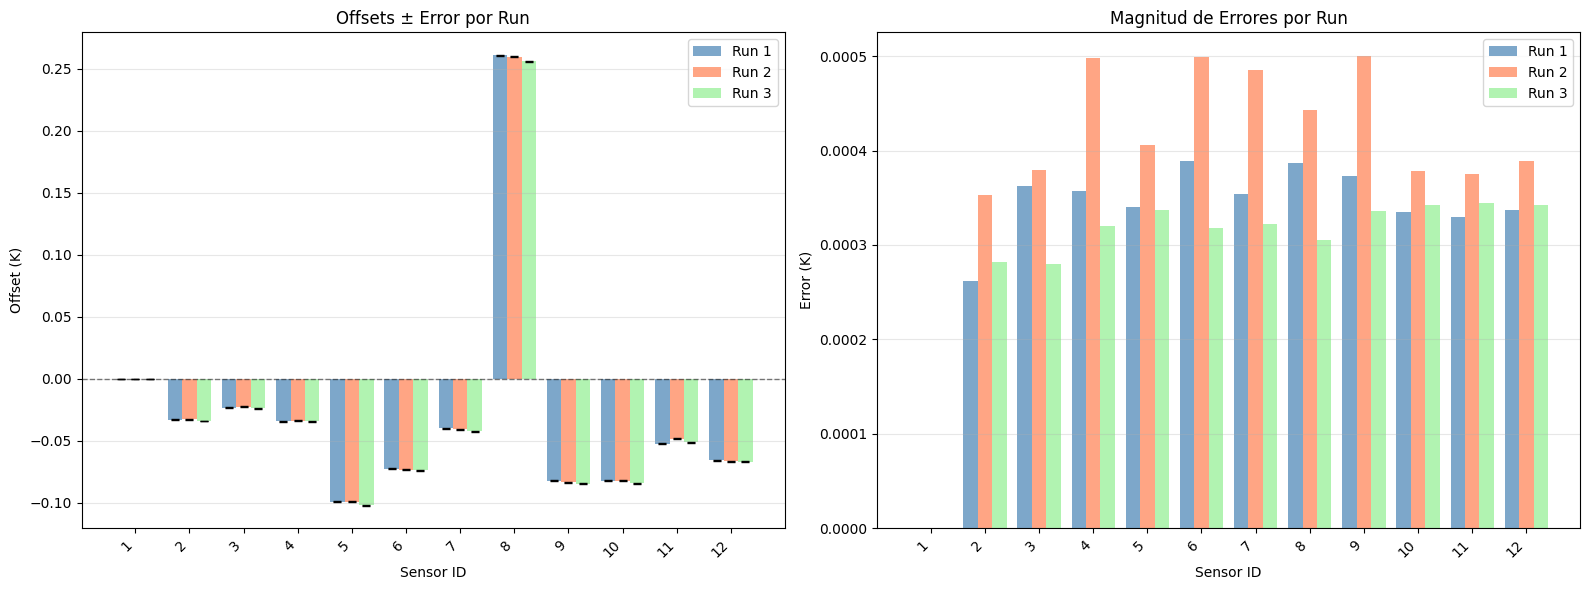


Estadísticas de errores por run:
Run 1:
  Error promedio: 0.000319 K
  Error mínimo:   0.000000 K
  Error máximo:   0.000389 K
Run 2:
  Error promedio: 0.000392 K
  Error mínimo:   0.000000 K
  Error máximo:   0.000500 K
Run 3:
  Error promedio: 0.000294 K
  Error mínimo:   0.000000 K
  Error máximo:   0.000344 K

✓ Runs con menor error tendrán mayor peso en la media ponderada de CalibSet


In [10]:
# Visualización comparativa de errores
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Preparar datos
sensor_ids = df_offsets.index.values
n_sensors = len(sensor_ids)
n_runs = len(runs)
x_pos = np.arange(n_sensors)
width = 0.8 / n_runs

# Plot 1: Offsets de cada run con barras de error
colors = ['steelblue', 'coral', 'lightgreen', 'gold']
for i, run in enumerate(runs):
    run_offsets = [run.offsets.get(sid, np.nan) for sid in sensor_ids]
    run_errors = [run.offset_errors.get(sid, 0.0) for sid in sensor_ids]
    
    ax1.bar(x_pos + i*width, run_offsets, width, 
            yerr=run_errors, label=f'Run {i+1}',
            alpha=0.7, color=colors[i % len(colors)],
            capsize=3, error_kw={'linewidth': 1})

ax1.set_xlabel('Sensor ID')
ax1.set_ylabel('Offset (K)')
ax1.set_title('Offsets ± Error por Run')
ax1.set_xticks(x_pos + width * (n_runs-1) / 2)
ax1.set_xticklabels(sensor_ids, rotation=45, ha='right')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.legend(loc='best')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Comparación de magnitud de errores entre runs
for i, run in enumerate(runs):
    run_errors = [run.offset_errors.get(sid, 0.0) for sid in sensor_ids]
    ax2.bar(x_pos + i*width, run_errors, width, 
            label=f'Run {i+1}', alpha=0.7, color=colors[i % len(colors)])

ax2.set_xlabel('Sensor ID')
ax2.set_ylabel('Error (K)')
ax2.set_title('Magnitud de Errores por Run')
ax2.set_xticks(x_pos + width * (n_runs-1) / 2)
ax2.set_xticklabels(sensor_ids, rotation=45, ha='right')
ax2.legend(loc='best')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de errores
print("\nEstadísticas de errores por run:")
print("=" * 70)
for i, run in enumerate(runs, 1):
    errors = [run.offset_errors.get(sid, 0.0) for sid in sensor_ids]
    print(f"Run {i}:")
    print(f"  Error promedio: {np.mean(errors):.6f} K")
    print(f"  Error mínimo:   {np.min(errors):.6f} K")
    print(f"  Error máximo:   {np.max(errors):.6f} K")

print("\n✓ Runs con menor error tendrán mayor peso en la media ponderada de CalibSet")

## 10. Demostración de filtrado de keywords y sensores descartados

In [11]:
# Demostrar filtrado de keywords
test_filenames = [
    "20220201_ln2_r48176_r48177_48060_48479_1",  # Válido
    "20220201_ln2_r48176_r48177_48060_48479_1_pre",  # PRE (excluir)
    "20220201_ln2_r48176_r48177_48060_48479_st_1",  # ST (excluir)
    "20220531_ln2_r48176_r48177_48060_48479_lar_7",  # LAR (excluir)
]

print("Prueba de filtrado por keywords:")
for fname in test_filenames:
    excluded = should_exclude_run(fname)
    status = "❌ EXCLUIR" if excluded else "✅ VÁLIDO"
    print(f"  {status}: {fname}")

print("\n" + "="*60)

# Demostrar sensores descartados
print("\nSensores descartados por set:")
for set_num in [3, 21, 39, 57]:
    discarded = get_discarded_sensors(set_num, config)
    if discarded:
        print(f"  Set {set_num}: {discarded}")
    else:
        print(f"  Set {set_num}: ninguno")

print("\n" + "="*60)

# Demostrar filtrado completo
print("\nRuns válidos vs totales en logfile:")
for set_num in [3, 21]:
    # Función auxiliar para convertir set numbers
    def get_set_number(x):
        try:
            return float(str(x).replace(',', '.'))
        except (ValueError, TypeError):
            return None
    
    logfile_temp = logfile.copy()
    logfile_temp['SetNum'] = logfile_temp['CalibSetNumber'].apply(get_set_number)
    
    # Total en set
    total_runs = len(logfile_temp[logfile_temp['SetNum'] == float(set_num)])
    
    # Válidos (usando nueva función)
    valid_runs = filter_valid_runs(logfile, set_num)
    
    print(f"  Set {set_num}: {len(valid_runs)}/{total_runs} válidos (excluidos: BAD + keywords)")


Prueba de filtrado por keywords:
  ✅ VÁLIDO: 20220201_ln2_r48176_r48177_48060_48479_1
  ❌ EXCLUIR: 20220201_ln2_r48176_r48177_48060_48479_1_pre
  ❌ EXCLUIR: 20220201_ln2_r48176_r48177_48060_48479_st_1
  ❌ EXCLUIR: 20220531_ln2_r48176_r48177_48060_48479_lar_7


Sensores descartados por set:
  Set 3: [48205, 48478]
  Set 21: [49191, 49200]
  Set 39: ninguno
  Set 57: ninguno


Runs válidos vs totales en logfile:
  Set 3: 4/18 válidos (excluidos: BAD + keywords)
  Set 21: 4/8 válidos (excluidos: BAD + keywords)


## 11. Función de alto nivel: process_run_complete()

**Esta es la función que debe usar el Tree para procesar runs.**

Aplica TODAS las validaciones automáticamente:
- ✓ Keywords excluidas ('pre', 'st', 'lar')
- ✓ Selection != 'BAD' en logfile
- ✓ Ventana temporal 20-40 min
- ✓ Solo 12 sensores (excluye refs en canales 13-14)
- ✓ Excluye sensores descartados (config.discarded)

In [12]:
# Demostrar uso de process_run_complete() - LA FUNCIÓN CORRECTA PARA EL TREE

# Obtener referencia del set 3
sets_dict = config.get('sensors', {}).get('sets', {})
set_3_config = sets_dict.get('3.0') or sets_dict.get('3') or sets_dict.get(3.0)

if set_3_config is None:
    print("⚠️  No se encontró configuración para el set 3")
    print(f"Claves disponibles: {list(sets_dict.keys())[:10]}")
else:
    ref_sensor = set_3_config.get('sensors', [])[0]

    print("=" * 70)
    print("PROCESAMIENTO COMPLETO CON VALIDACIONES AUTOMÁTICAS")
    print("=" * 70)

    # Probar con diferentes tipos de runs
    test_cases = [
        "20220531_ln2_r48176_r48177_48060_48479_7",      # Válido
        "20220531_ln2_r48176_r48177_48060_48479_7_pre",  # Pre (excluir)
        "20220531_ln2_r48176_r48177_48060_48479_8",      # Válido
    ]

    valid_runs = []

    for fname in test_cases:
        print(f"\n📁 Procesando: {fname}")
        
        # UNA SOLA LLAMADA - TODO AUTOMÁTICO
        # NOTA: reference_channel es el número de canal (1-14), no el ID del sensor
        run = process_run_complete(
            filename=fname,
            logfile=logfile,
            config=config,
            set_number=3,
            reference_channel=1,  # Primer sensor del set = canal 1
            time_window=(20, 40)  # Default, puede omitirse
        )
        
        # Verificar resultado
        if run.is_valid and run.offsets:
            print(f"   ✅ VÁLIDO: {len(run.offsets)} offsets calculados")
            valid_runs.append(run)
        elif not run.is_valid:
            print(f"   ❌ INVÁLIDO: run.is_valid = False")
        elif not run.offsets:
            print(f"   ⚠️  VÁLIDO pero sin offsets (archivo corto?)")

    print("\n" + "=" * 70)
    print(f"✓ Resultado final: {len(valid_runs)} runs válidos con offsets")
    print("=" * 70)

    # Mostrar offsets del primer run válido
    if valid_runs:
        print(f"\n📊 Offsets del primer run válido ({valid_runs[0].filename}):")
        for sensor_id, offset in list(valid_runs[0].offsets.items())[:5]:
            print(f"   Sensor {sensor_id}: {offset:+.4f} K")
        print(f"   ... (total {len(valid_runs[0].offsets)} sensores)")


PROCESAMIENTO COMPLETO CON VALIDACIONES AUTOMÁTICAS

📁 Procesando: 20220531_ln2_r48176_r48177_48060_48479_7
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_7: 821 registros, 14 canales
   ✅ VÁLIDO: 12 offsets calculados

📁 Procesando: 20220531_ln2_r48176_r48177_48060_48479_7_pre
[WARNING] Run '20220531_ln2_r48176_r48177_48060_48479_7_pre' excluido por keywords
   ❌ INVÁLIDO: run.is_valid = False

📁 Procesando: 20220531_ln2_r48176_r48177_48060_48479_8
  [OK] Cargado 20220531_ln2_r48176_r48177_48060_48479_8: 2260 registros, 14 canales
   ✅ VÁLIDO: 12 offsets calculados

✓ Resultado final: 2 runs válidos con offsets

📊 Offsets del primer run válido (20220531_ln2_r48176_r48177_48060_48479_7):
   Sensor 1: +0.0000 K
   Sensor 2: -0.0330 K
   Sensor 3: -0.0233 K
   Sensor 4: -0.0342 K
   Sensor 5: -0.0992 K
   ... (total 12 sensores)


## 11b. Validación de canales defectuosos (NaN threshold)

**Demostración de la detección automática de canales con muchos NaN**

Config en `config.yml`:
```yaml
run_options:
  max_nan_threshold: 40  # Número ABSOLUTO de NaN permitidos (no %)
```

Si un canal tiene >40 registros con NaN en la ventana [20-40min], se considera defectuoso.

In [13]:
# Verificar configuración de NaN threshold
print("Configuración de validación de canales defectuosos:")
print("=" * 60)

run_options = config.get('run_options', {})
max_nan_threshold = run_options.get('max_nan_threshold', 40)
valid_temp_range = run_options.get('valid_temp_range', {})

print(f"max_nan_threshold: {max_nan_threshold} registros")
print(f"  → Si un sensor tiene >{max_nan_threshold} registros con NaN en la ventana [20-40min],")
print(f"    se considera DEFECTUOSO y se excluye automáticamente")
print()
print(f"valid_temp_range: {valid_temp_range.get('min', 60)} - {valid_temp_range.get('max', 350)} K")
print(f"  → Valores fuera de este rango se marcan como NaN")

print("\n" + "=" * 60)
print("Ejemplo: Procesar un run con canales defectuosos (muchos NaN)")
print("=" * 60)

# Procesar run específico del set 25 que tiene canales con muchos NaN
sets_dict = config.get('sensors', {}).get('sets', {})
set_25_config = sets_dict.get('25.0') or sets_dict.get('25') or sets_dict.get(25.0)

if set_25_config is None:
    print("⚠️  No se encontró configuración para el set 25")
    print(f"Claves disponibles: {list(sets_dict.keys())[:10]}")
else:
    ref_sensor = set_25_config.get('sensors', [])[0]

    # Run específico del set 25 con canales defectuosos
    test_filename = "20250407_ln2_r49265_r49264_49250-49261_2"
    
    print(f"\nProcesando run: {test_filename}")
    print(f"Set: 25")
    print(f"Referencia: sensor {ref_sensor} (canal 1)")
    print(f"(Observa si algún sensor se omite por >{max_nan_threshold} NaN)\n")

    # Procesar con validaciones completas
    # NOTA: reference_channel es el número de canal (1-14), no el ID del sensor
    run_test = process_run_complete(
        filename=test_filename,
        logfile=logfile,
        config=config,
        set_number=25,
        reference_channel=1,  # Primer sensor del set = canal 1
        time_window=(20, 40)
    )

    print(f"\n📊 Resultado del procesamiento:")
    print(f"  ✓ Run válido: {run_test.is_valid}")
    print(f"  ✓ Referencia usada: canal {run_test.reference_channel}")
    print(f"  ✓ Canales procesados: {len(run_test.temperatures.columns) if run_test.temperatures is not None else 0}")
    print(f"  ✓ Offsets calculados: {len(run_test.offsets)} canales")
    print(f"  ✓ Canales omitidos: {len(run_test.omitted_channels)}")
    
    print("\n" + "=" * 60)
    
    if run_test.offsets:
        print("Offsets válidos por CANAL (Run es ciego a IDs):")
        for channel, offset in list(run_test.offsets.items())[:3]:
            print(f"  ✓ Canal {channel}: {offset:+.4f} K")
        if len(run_test.offsets) > 3:
            print(f"  ... y {len(run_test.offsets) - 3} canales más")
    
    if run_test.omitted_channels:
        print("\n" + "=" * 60)
        print("Canales omitidos (NO se usan en medias ponderadas):")
        for channel, reason in run_test.omitted_channels.items():
            print(f"  ✗ Canal {channel}: {reason}")
        
        # Desglosar por tipo de omisión
        discarded_count = sum(1 for r in run_test.omitted_channels.values() if 'descartado' in r)
        defective_count = sum(1 for r in run_test.omitted_channels.values() if 'defectuoso' in r)
        
        print(f"\n  Total omitidos: {len(run_test.omitted_channels)}")
        print(f"    - Descartados en config: {discarded_count}")
        print(f"    - Defectuosos (>{max_nan_threshold} NaN): {defective_count}")
    
    print("\n" + "=" * 60)
    print("✅ GARANTÍA PARA CALIBSET:")
    print(f"   Solo los {len(run_test.offsets)} offsets válidos se usarán")
    print(f"   Los {len(run_test.omitted_channels)} canales omitidos NUNCA entrarán en cálculos")
    print(f"   CalibSet hace el mapping canal→sensor usando sensors[channel-1]")
    print("=" * 60)

Configuración de validación de canales defectuosos:
max_nan_threshold: 40 registros
  → Si un sensor tiene >40 registros con NaN en la ventana [20-40min],
    se considera DEFECTUOSO y se excluye automáticamente

valid_temp_range: 60 - 350 K
  → Valores fuera de este rango se marcan como NaN

Ejemplo: Procesar un run con canales defectuosos (muchos NaN)

Procesando run: 20250407_ln2_r49265_r49264_49250-49261_2
Set: 25
Referencia: sensor 49250 (canal 1)
(Observa si algún sensor se omite por >40 NaN)

  [OK] Cargado 20250407_ln2_r49265_r49264_49250-49261_2: 651 registros, 14 canales

📊 Resultado del procesamiento:
  ✓ Run válido: True
  ✓ Referencia usada: canal 1
  ✓ Canales procesados: 14
  ✓ Offsets calculados: 12 canales
  ✓ Canales omitidos: 0

Offsets válidos por CANAL (Run es ciego a IDs):
  ✓ Canal 1: +0.0000 K
  ✓ Canal 2: -0.0183 K
  ✓ Canal 3: +0.0362 K
  ... y 9 canales más

✅ GARANTÍA PARA CALIBSET:
   Solo los 12 offsets válidos se usarán
   Los 0 canales omitidos NUNCA ent

## 11c. Verificación final: Run almacena toda la información

**El objeto Run ahora tiene:**
- `run.is_valid`: `True` solo si pasa TODAS las validaciones (no BAD, no keywords)
- `run.offsets`: `{sensor_id: offset}` SOLO sensores válidos y filtrados
- `run.omitted_sensors`: `{sensor_id: razón}` sensores excluidos con explicación
- `run.reference_id`: sensor usado como referencia

**Para el Tree:**
```python
# Pseudocódigo CalibrationSet
for filename in all_run_files:
    run = utils.process_run_complete(...)
    
    # ✓ Solo agregar si válido Y tiene offsets
    if run.is_valid and run.offsets:
        calibration_set.runs.append(run)
        
        # Al calcular media ponderada, usar solo run.offsets
        for sensor_id, offset in run.offsets.items():
            all_offsets[sensor_id].append(offset)
```

**Garantías:**
1. ✅ `run.offsets` contiene SOLO sensores que pasaron TODAS las validaciones
2. ✅ Ventana temporal [20-40min] ya aplicada
3. ✅ Canales defectuosos (>40 NaN) ya excluidos
4. ✅ Sensores descartados (config) ya excluidos
5. ✅ Referencias externas (canales 13-14) nunca incluidas
6. ✅ `run.is_valid = False` si tiene keywords ('pre', 'st', 'lar') o es 'BAD'

In [14]:
# Demostración de cómo el Tree debe usar los runs

print("=" * 70)
print("SIMULACIÓN: Cómo el Tree procesaría múltiples runs")
print("=" * 70)

# Obtener runs válidos del set 25
valid_filenames = filter_valid_runs(logfile, set_number=25)
print(f"\nSet 25 tiene {len(valid_filenames)} runs válidos en logfile")
print("Procesando primeros 3 runs...\n")

# Simular procesamiento del Tree
valid_runs = []
all_offsets_by_sensor = {}  # {sensor_id: [offset1, offset2, ...]}

sets_dict = config.get('sensors', {}).get('sets', {})
set_25_config = sets_dict.get('25.0') or sets_dict.get('25') or sets_dict.get(25.0)

if set_25_config:
    ref_sensor = set_25_config.get('sensors', [])[0]
    
    for i, fname in enumerate(valid_filenames[:3], 1):
        print(f"[{i}/3] Procesando: {fname}")
        
        # NOTA: reference_channel es el número de canal (1-14), no el ID del sensor
        run = process_run_complete(
            filename=fname,
            logfile=logfile,
            config=config,
            set_number=25,
            reference_channel=1,  # Primer sensor del set = canal 1
            time_window=(20, 40)
        )
        
        # ✓ Verificar validación
        if run.is_valid and run.offsets:
            valid_runs.append(run)
            print(f"     ✅ VÁLIDO: {len(run.offsets)} offsets, {len(run.omitted_channels)} omitidos")
            
            # Acumular offsets por CANAL (Run es ciego)
            # NOTA: En producción, CalibSet haría el mapping canal→sensor
            for channel, offset in run.offsets.items():
                if channel not in all_offsets_by_sensor:
                    all_offsets_by_sensor[channel] = []
                all_offsets_by_sensor[channel].append(offset)
        else:
            print(f"     ❌ EXCLUIDO: is_valid={run.is_valid}, offsets={len(run.offsets)}")
    
    print("\n" + "=" * 70)
    print(f"✓ Resultado: {len(valid_runs)} runs válidos procesados")
    print("=" * 70)
    
    # Calcular medias ponderadas (como lo haría CalibrationSet)
    if valid_runs:
        print("\nMedias simples de offsets por CANAL (simulación):")
        print("(En producción, CalibSet mapea canal→sensor usando sensors[channel-1])")
        for channel in sorted(all_offsets_by_sensor.keys())[:5]:
            offsets = all_offsets_by_sensor[channel]
            mean_offset = sum(offsets) / len(offsets)
            print(f"  Canal {channel}: {mean_offset:+.4f} K (promedio de {len(offsets)} runs)")
        
        if len(all_offsets_by_sensor) > 5:
            print(f"  ... y {len(all_offsets_by_sensor) - 5} canales más")
        
        print(f"\n✅ Total: {len(all_offsets_by_sensor)} canales con offsets válidos")
        print(f"✅ CalibSet usaría estos para crear offsets por sensor")
        
        # Mostrar resumen de omisiones
        total_omitted = sum(len(run.omitted_channels) for run in valid_runs)
        if total_omitted > 0:
            print(f"\n⚠️  Total de canales omitidos en todos los runs: {total_omitted}")
            print(f"   (Estos NUNCA entran en las medias ponderadas)")
else:
    print("⚠️  No se pudo obtener configuración del set 25")

SIMULACIÓN: Cómo el Tree procesaría múltiples runs

Set 25 tiene 4 runs válidos en logfile
Procesando primeros 3 runs...

[1/3] Procesando: 20250407_ln2_r49265_r49264_49250-49261_1
  [OK] Cargado 20250407_ln2_r49265_r49264_49250-49261_1: 707 registros, 14 canales
     ✅ VÁLIDO: 12 offsets, 0 omitidos
[2/3] Procesando: 20250407_ln2_r49265_r49264_49250-49261_2
  [OK] Cargado 20250407_ln2_r49265_r49264_49250-49261_2: 651 registros, 14 canales
     ✅ VÁLIDO: 12 offsets, 0 omitidos
[3/3] Procesando: 20250407_ln2_r49265_r49264_49250-49261_3
  [OK] Cargado 20250407_ln2_r49265_r49264_49250-49261_3: 670 registros, 14 canales
     ✅ VÁLIDO: 12 offsets, 0 omitidos

✓ Resultado: 3 runs válidos procesados

Medias simples de offsets por CANAL (simulación):
(En producción, CalibSet mapea canal→sensor usando sensors[channel-1])
  Canal 1: +0.0000 K (promedio de 3 runs)
  Canal 2: -0.0182 K (promedio de 3 runs)
  Canal 3: +0.0363 K (promedio de 3 runs)
  Canal 4: +0.0197 K (promedio de 3 runs)
  Canal 

## 11d. Ejemplo: Exportar Runs a CSV

**Dos funciones de exportación para Runs:**

1. `export_run_to_csv(run)` - Exporta un run individual
2. `export_multiple_runs_to_csv(runs)` - Exporta múltiples runs consolidados

In [15]:
print("=" * 60)
print("⚠️  FUNCIONES DE EXPORTACIÓN PENDIENTES DE IMPLEMENTACIÓN")
print("=" * 60)

print("\nEstas funciones están documentadas pero aún no implementadas:")
print("  - export_run_to_csv(run, set_number, output_path)")
print("  - export_multiple_runs_to_csv(runs, set_number, output_path)")

print("\n💡 Por ahora, los datos están disponibles en memoria:")
print(f"   - {len(runs)} runs procesados en la variable 'runs'")
print(f"   - Cada run tiene: offsets, offset_errors, omitted_channels")

print("\n📝 Ejemplo de acceso manual a los datos:")
if runs:
    print(f"\n   Run 1: {runs[0].filename}")
    print(f"   - Offsets: {dict(list(runs[0].offsets.items())[:3])}...")
    print(f"   - Canales omitidos: {len(runs[0].omitted_channels)}")
    
    # Crear DataFrame simple como ejemplo
    print("\n   Puedes crear un DataFrame manualmente:")
    example_data = []
    for run in runs[:1]:  # Solo primer run como ejemplo
        for channel, offset in run.offsets.items():
            example_data.append({
                'filename': run.filename,
                'channel': channel,
                'offset': offset,
                'offset_error': run.offset_errors.get(channel, 0.0)
            })
    
    df_example = pd.DataFrame(example_data)
    print(f"\n   DataFrame de ejemplo ({len(df_example)} filas):")
    display(df_example.head())
else:
    print("   No hay runs disponibles en memoria")

# # CÓDIGO COMENTADO - Para cuando se implementen las funciones
# # Ejemplo 1: Exportar un run individual
# if runs:
#     csv_path = utils.export_run_to_csv(
#         run=runs[0],
#         set_number=3,
#         output_path="../data/results/example_run.csv"
#     )
#     print(f"\n✓ Run exportado: {csv_path}")
# 
# # Ejemplo 2: Exportar múltiples runs
# csv_path = utils.export_multiple_runs_to_csv(
#     runs=runs,
#     set_number=3,
#     output_path="../data/results/runs_set_3.csv"
# )

⚠️  FUNCIONES DE EXPORTACIÓN PENDIENTES DE IMPLEMENTACIÓN

Estas funciones están documentadas pero aún no implementadas:
  - export_run_to_csv(run, set_number, output_path)
  - export_multiple_runs_to_csv(runs, set_number, output_path)

💡 Por ahora, los datos están disponibles en memoria:
   - 3 runs procesados en la variable 'runs'
   - Cada run tiene: offsets, offset_errors, omitted_channels

📝 Ejemplo de acceso manual a los datos:

   Run 1: 20220531_ln2_r48176_r48177_48060_48479_7
   - Offsets: {1: np.float64(0.0), 2: np.float64(-0.03300854545454589), 3: np.float64(-0.023257575757576008)}...
   - Canales omitidos: 0

   Puedes crear un DataFrame manualmente:

   DataFrame de ejemplo (12 filas):


,filename,channel,offset,offset_error
0,20220531_ln2_r48176_r48177_48060_48479_7,1,0.000000,0.000000
1,20220531_ln2_r48176_r48177_48060_48479_7,2,-0.033009,0.000262
2,20220531_ln2_r48176_r48177_48060_48479_7,3,-0.023258,0.000363
3,20220531_ln2_r48176_r48177_48060_48479_7,4,-0.034180,0.000357
4,20220531_ln2_r48176_r48177_48060_48479_7,5,-0.099238,0.000340


## 12. Resumen

**Clase Run (~70 líneas):**
```python
class Run:
    filename: str
    timestamps: DatetimeIndex
    temperatures: DataFrame
    sensor_ids: List[int]
    offsets: Dict[int, float]         # offset por sensor (ya filtrados)
    offset_errors: Dict[int, float]   # error por sensor
    omitted_sensors: Dict[int, str]   # {sensor_id: razón}
    reference_id: int
    is_valid: bool                     # False si BAD o keywords
```

**Flujo recomendado para CalibSet:**
```python
run = utils.process_run_complete(
    filename, logfile, config, set_number, reference_id
)

if run.is_valid and run.offsets:
    # Solo usar run.offsets (ya filtrados)
    calibration_set.runs.append(run)
```

**Funciones principales en utils.py:**
```
# Básicas
- load_config(), propagate_error(), ensure_numeric()
- get_run_metadata(), validate_sensor_in_set()

# Filtrado
- should_exclude_run(filename)              # 'pre', 'st', 'lar'
- filter_valid_runs(logfile, set_num)       # Válidos del set
- get_discarded_sensors(set_num, config)    # Descartados

# Procesamiento Run
- load_run_from_file(filename, config)      # Carga .txt
- map_sensor_ids_to_run(run, logfile)       # Mapea IDs
- calculate_run_offsets(run, ref, config)   # Calcula offsets + errores
- process_run_complete(...)                 # TODO EN UNO (usar en CalibSet)

# Exportación CSV (clase Run)
- export_run_to_csv(run)                    # 1 run individual
- export_multiple_runs_to_csv(runs)         # Múltiples runs consolidados
```

**Validaciones automáticas (process_run_complete):**
1. Keywords excluidas ('pre', 'st', 'lar') → `is_valid = False`
2. Selection = 'BAD' → `is_valid = False`
3. Ventana temporal [20-40min]
4. Solo 12 sensores (excluye refs canales 13-14)
5. Sensores descartados → `omitted_sensors`
6. Canales >40 NaN → `omitted_sensors`
7. Rango temp 60-350 K

**Garantías para CalibSet:**
- `run.offsets` = SOLO sensores válidos (ya filtrados)
- `run.offset_errors` = Error de cada offset (para media ponderada)
- `run.is_valid` = True solo si pasa todas las validaciones
- `run.omitted_sensors` = Documentación de exclusiones

**Exportación CSV:**
```python
# Run individual
utils.export_run_to_csv(run, set_number=3)

# Múltiples runs
utils.export_multiple_runs_to_csv(runs, set_number=3)

# Leer CSV
df = pd.read_csv('runs_set_3.csv')
# Columnas: set_number, filename, sensor_id, offset, offset_error, 
#           reference_id, omitted_reason
```

**Siguiente paso:** CalibSet class (media ponderada por error)
- export_set_offsets_to_csv(...)            # 1 set
- export_multiple_sets_to_csv(...)          # Varios o todos
```

**Validaciones automáticas (process_run_complete):**
1. Keywords excluidas ('pre', 'st', 'lar') → `is_valid = False`
2. Selection = 'BAD' → `is_valid = False`
3. Ventana temporal [20-40min]
4. Solo 12 sensores (excluye refs canales 13-14)
5. Sensores descartados → `omitted_sensors`
6. Canales >40 NaN → `omitted_sensors`
7. Rango temp 60-350 K

**Garantías para Tree:**
- `run.offsets` = SOLO sensores válidos (ya filtrados)
- `run.is_valid` = True solo si pasa todo
- `run.omitted_sensors` = Documentación de exclusiones

**Exportación CSV (opcional):**
```python
# Set individual
utils.export_set_offsets_to_csv(logfile, config, 25)

# Múltiples sets
utils.export_multiple_sets_to_csv(logfile, config, [3,21,25])

# TODOS los sets
utils.export_multiple_sets_to_csv(logfile, config)

# Leer caché
df = pd.read_csv('set_25_offsets.csv')
mean = df[df['offset'].notna()].groupby('sensor_id')['offset'].mean()
```

**Siguiente paso:** CalibrationSet class